## Imports

In [105]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay

## Functions

In [96]:
def create_seq(dataset, target, features):
    
    sequence_len = 48
    X = []
    y = []

    for i in range(sequence_len + 120, len(dataset) - sequence_len):
        X_temp = dataset[features].iloc[i - sequence_len - 120 : i - 120].values
        y_temp = dataset[target].iloc[i]
    
        X.append(X_temp)
        y.append(y_temp)

    X = np.array(X)
    y = np.array(y)
    
    return X, y


def lstm_model(dataset, feature_cols, target_col, train_size, sequence_len=48, 
               lstm_units1=50, lstm_units2=50, dropout1=0.2, dropout2=0.2, dense_units=25, epochs=30, batch_size=32):

    
    def build_lstm_model(sequence_length, feature_count):
        model = Sequential([
            LSTM(lstm_units1, activation='relu', return_sequences=True, input_shape=(sequence_length, feature_count)),
            Dropout(dropout1),
            LSTM(lstm_units2, activation='relu', return_sequences=False),
            Dropout(dropout2),
            Dense(dense_units),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def create_sequences(features, target, sequence_len):
        X, y = [], []
        for i in range(sequence_len + 120, len(features)):
            X.append(features[i - sequence_len - 120 : i - 120]) # use past week of data
            y.append(target[i])
        return np.array(X), np.array(y)
    
    X_data = dataset[feature_cols].values
    y_data = dataset[target_col].values
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    features_scaled = scaler.fit_transform(X_data)

    X, y = create_sequences(features_scaled, y_data, sequence_len)
    train_lim = int(len(X) * train_size)
    X_train, X_test = X[:train_lim], X[train_lim:]
    y_train, y_test = y[:train_lim], y[train_lim:]

    # Define the LSTM model
    feature_count = len(feature_cols)
    model = build_lstm_model(sequence_len, feature_count)

    # Fit the model
    print('Fitting the model:')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping], class_weight={0:1, 1:5}, verbose=1) # added class weight to penalize False Negatives

    return model, history, X_train, X_test, y_train, y_test


def gridsearch(X, y, sequence_length, feature_count):
    
    
    def build_tuned_model(hp):
        model = Sequential([
            LSTM(hp.Int('units1', min_value=32, max_value=128, step=16), activation='relu', return_sequences=True, input_shape=(sequence_length, feature_count)),
            Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)),
            LSTM(hp.Int('units2', min_value=32, max_value=128, step=16), activation='relu', return_sequences=False),
            Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)),
            Dense(hp.Int('dense_units', 10, 50, step=10)),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # We consuct hyperparameter tuning to find optimal params
    tuner = RandomSearch(
        build_tuned_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
    )

    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    # Retrieve the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print('Optimal units in LSTM_1 layers: ', best_hps.get('units1'))
    print('Optimal units in LSTM_2 layers: ', best_hps.get('units2'))
    print('Optimal dropout_1 rate: ', best_hps.get('dropout1'))
    print('Optimal dropout_2 rate: ', best_hps.get('dropout2'))
    print('Optimal dense layer units: ', best_hps.get('dense_units'))
    

def visualize_lstm(history):
    
    # Visualize Training loss graph
    print('Loss Graph:')
    plt.figure(figsize=(12,6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.legend()
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Visualize Validation loss graph
    print('Loss Graph:')
    plt.figure(figsize=(12,6))
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    
def auc_plot(y_test, y_pred):
    
    # Compute AUC
    auc = roc_auc_score(y_test, y_pred)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

## Data

In [3]:
# Load dataset
root = '../data/'
path = 'ml_features.csv'
df = pd.read_csv(os.path.join(root,path))
df["date"] = pd.to_datetime(df["date"])
df.set_index('date', inplace=True)
df.dropna(inplace=True)
df

,rt_prices,da_prices,load_realized,load_forecast,capacity,temperature,humidity,precipitation,wind_speed,wind_direction,...,spike_60,past_spikes_30,past_spikes_45,past_spikes_60,past_da_load_error,past_da_price_error,is_weekend,hour,month,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,128.915833,128.46,2499.016667,2330.0,2717.500000,-12.952500,62.0,0.0,7.127636,315.00010,...,0,2.0,1.0,0.0,8.657710e+05,18265.332557,0,1,1,0
2018-01-01 02:00:00,131.331667,124.63,2394.441667,2238.0,2713.333333,-12.752501,61.0,0.0,8.209263,307.87503,...,0,2.0,1.0,0.0,9.323887e+05,18909.514557,0,2,1,0
2018-01-01 03:00:00,136.922500,125.83,2331.325000,2188.0,2650.000000,-12.602500,60.0,0.0,9.832680,293.74950,...,0,3.0,1.0,0.0,9.865578e+05,19498.749824,0,3,1,0
2018-01-01 04:00:00,125.941667,123.65,2308.791667,2177.0,2674.166667,-12.952500,62.0,0.0,9.028754,293.49857,...,0,4.0,1.0,0.0,1.030178e+06,20912.901655,0,4,1,0
2018-01-01 05:00:00,122.996667,127.28,2321.550000,2198.0,2695.000000,-12.702500,62.0,0.0,9.085988,303.69010,...,0,4.0,1.0,0.0,1.063819e+06,21640.850085,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,32.165833,36.94,2468.963167,2536.0,3000.000000,5.347500,53.0,0.0,16.862455,286.11350,...,0,1.0,1.0,1.0,2.378046e+05,4643.051269,1,19,12,0
2023-12-31 20:00:00,33.734167,35.68,2358.665175,2448.0,3000.000000,5.397500,51.0,0.0,13.104197,285.94547,...,0,0.0,0.0,0.0,2.293922e+05,955.965258,1,20,12,0
2023-12-31 21:00:00,33.896667,34.62,2255.596967,2358.0,3000.000000,5.047500,53.0,0.0,10.315115,299.24872,...,0,0.0,0.0,0.0,2.295808e+05,916.772151,1,21,12,0


### Threshold: 30

In [4]:
# Build dataset for threshold 30
target_col_30 = 'spike_30'
feature_cols_30 = ['past_spikes_30', 'hdd', 
                   'cdd', 'past_da_load_error', 'past_da_price_error', 'month', 
                   'hour', 'is_weekend', 'is_holiday', 'load_capacity_ratio']

df_30 = df.copy()
df_30 = df_30[[target_col_30] + feature_cols_30]
df_30

,spike_30,past_spikes_30,hdd,cdd,past_da_load_error,past_da_price_error,month,hour,is_weekend,is_holiday,load_capacity_ratio
date,,,,,,,,,,,
2018-01-01 01:00:00,0,2.0,31.252500,0.0,8.657710e+05,18265.332557,1,1,0,0,0.857406
2018-01-01 02:00:00,1,2.0,31.052501,0.0,9.323887e+05,18909.514557,1,2,0,0,0.824816
2018-01-01 03:00:00,1,3.0,30.902500,0.0,9.865578e+05,19498.749824,1,3,0,0,0.825660
2018-01-01 04:00:00,0,4.0,31.252500,0.0,1.030178e+06,20912.901655,1,4,0,0,0.814085
2018-01-01 05:00:00,1,4.0,31.002500,0.0,1.063819e+06,21640.850085,1,5,0,0,0.815584
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0,1.0,12.952500,0.0,2.378046e+05,4643.051269,12,19,1,0,0.845333
2023-12-31 20:00:00,0,0.0,12.902500,0.0,2.293922e+05,955.965258,12,20,1,0,0.816000
2023-12-31 21:00:00,0,0.0,13.252500,0.0,2.295808e+05,916.772151,12,21,1,0,0.786000


In [38]:
# Create a shifted dataset so that we forecast 48h-ahead
# This is needed for the gridsearch
X_30, y_30 = create_seq(df_30, target_col_30, feature_cols_30)

In [39]:
# Perform gridsearch to optimize parameters
shutil.rmtree("untitled_project", ignore_errors=True)
opt_param_30 = gridsearch(X=X_30,
                          y=y_30, 
                          sequence_length=48, 
                          feature_count=len(feature_cols_30))

Trial 10 Complete [00h 04m 37s]
val_loss: 5.135557174682617

Best val_loss So Far: 0.2819153964519501
Total elapsed time: 00h 54m 49s
Optimal units in LSTM_1 layers:  128
Optimal units in LSTM_2 layers:  64
Optimal dropout_1 rate:  0.30000000000000004
Optimal dropout_2 rate:  0.1
Optimal dense layer units:  40


In [97]:
# Build LSTM model (train 2018-2022, test 2023)
train_size = 0.8
model_30, history_30, X_train_30, X_test_30, y_train_30, y_test_30 = lstm_model(dataset=df_30,
                                                                                feature_cols=feature_cols_30,
                                                                                target_col=target_col_30,
                                                                                train_size=train_size, 
                                                                                sequence_len=48,
                                                                                lstm_units1=128,
                                                                                lstm_units2=64,
                                                                                dropout1=0.3,
                                                                                dropout2=0.1,
                                                                                dense_units=40,
                                                                                epochs=30, 
                                                                                batch_size=32)

Fitting the model:
Epoch 1/30


C:\Users\vlari\PycharmProjects\electricty_trading\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - accuracy: 0.9180 - loss: 0.8028 - val_accuracy: 0.8978 - val_loss: 0.4193
Epoch 2/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.9072 - loss: 0.7701 - val_accuracy: 0.9071 - val_loss: 0.4444
Epoch 3/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.9015 - loss: 0.7781 - val_accuracy: 0.8988 - val_loss: 0.4246
Epoch 4/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8857 - loss: 398.2286 - val_accuracy: 0.9048 - val_loss: 0.4214
Epoch 5/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8924 - loss: 0.7778 - val_accuracy: 0.9083 - val_loss: 0.3999
Epoch 6/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8975 - loss: 0.7545 - val_accuracy: 0.9112 - val_loss: 0.4043
Epoch 7/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8871 - loss: 0.7572 - val_accuracy: 0.8605 - val_loss: 0.4325
Epoch 8/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8626 - loss: 0.

Loss Graph:


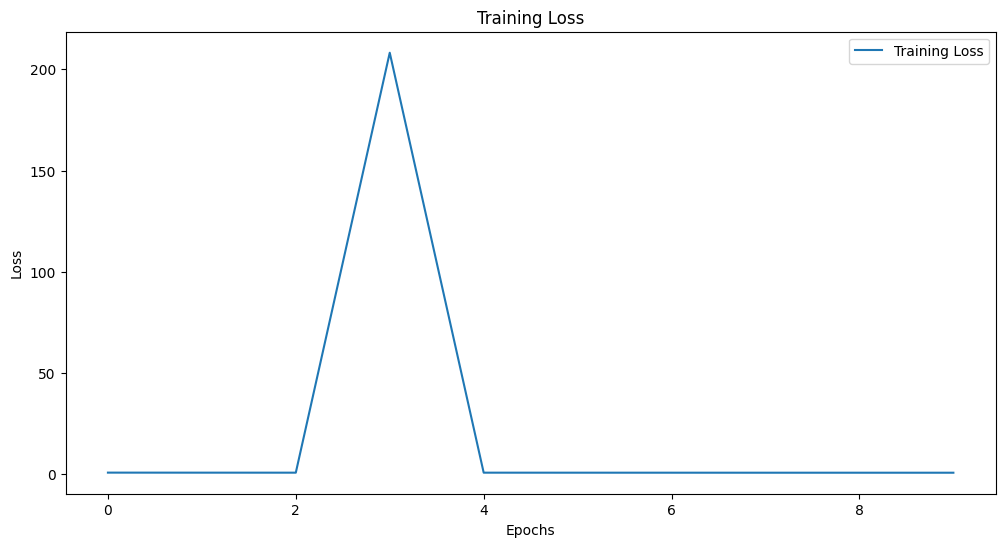

Loss Graph:


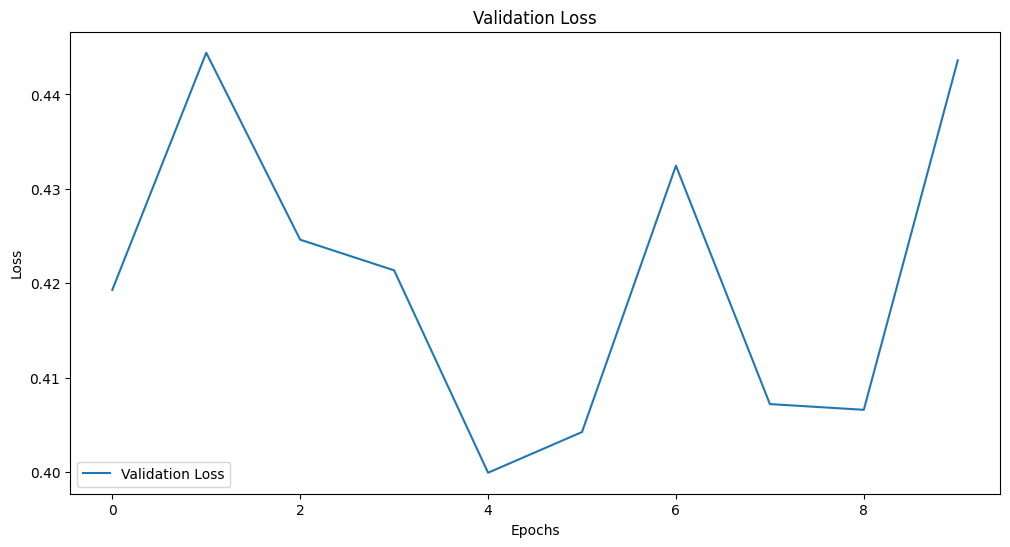

In [98]:
# Display loss graphs
visualize_lstm(history_30)

In [99]:
# Compute predicted spike probabilities
y_pred_30 = model_30.predict(X_test_30).ravel()
y_pred_30

325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


array([0.11259238, 0.11689822, 0.1299753 , ..., 0.31610578, 0.26799136,
       0.2245462 ], dtype=float32)

In [117]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (y_pred_30 >= t).astype(int)
    f1 = f1_score(y_test_30, y_pred)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold (by F1):", best_threshold)


Best threshold (by F1): 0.32


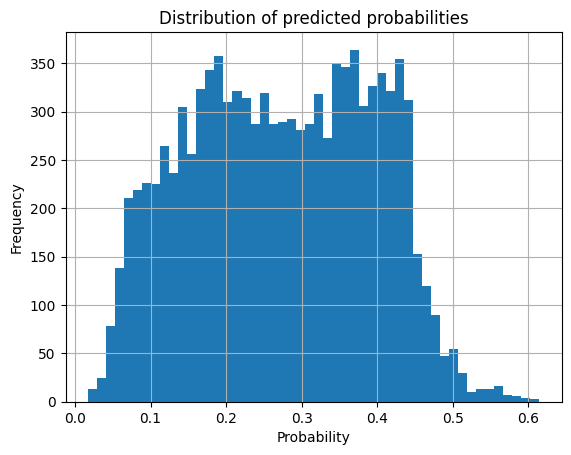

In [101]:
plt.hist(y_pred_30, bins=50)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [108]:
y_pred_30_binary = (y_pred_30 >= 0.4).astype(int)
y_pred_30_binary

array([0, 0, 0, ..., 0, 0, 0])

In [113]:
# Save prediction results 
df_pred = pd.DataFrame(y_pred_30_binary, columns=['predicted_spike'])
df_pred.to_csv('LSTM_predictions_30.csv', index=False)

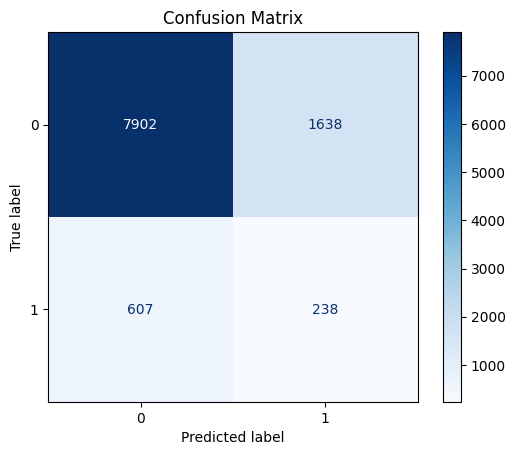

In [115]:
cm = confusion_matrix(y_test_30, y_pred_30_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

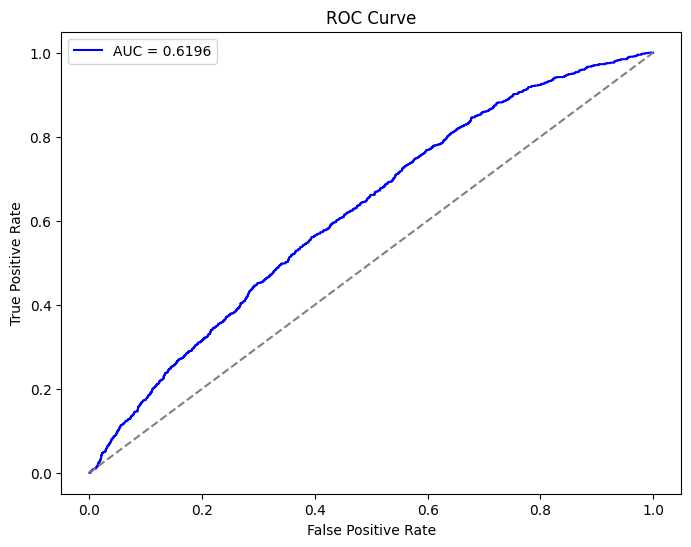

In [114]:
# Display AUC plot
auc_plot(y_test_30, y_pred_30)

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step


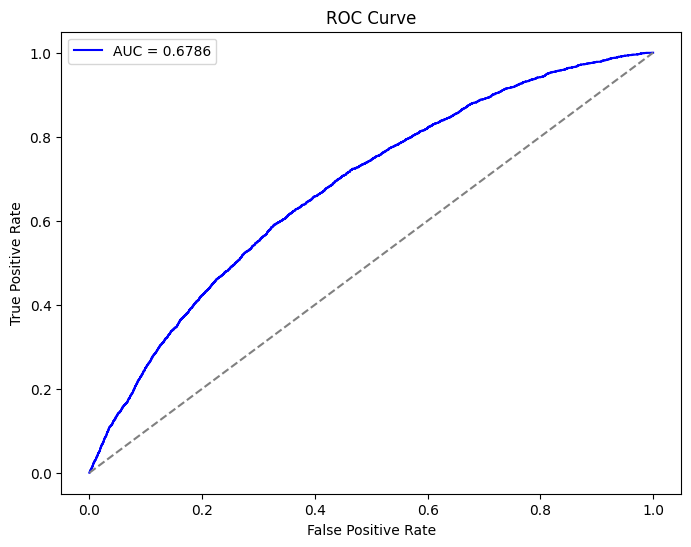

In [92]:
y_pred_train_30 = model_30.predict(X_train_30)
auc_plot(y_train_30, y_pred_train_30)

In [84]:
# Compute average log-likelihood
p_30 = np.clip(y_pred_30, 1e-9, 1 - 1e-9)

log_lik_30 = y_test_30 * np.log(p_30) + (1 - y_test_30) * np.log(1 - p_30)
avg_log_likelihood_30 = np.mean(log_lik_30)

print("Average Log-Likelihood:", avg_log_likelihood_30)

Average Log-Likelihood: -0.6078359070467616


### Threshold: 45

In [50]:
# Build dataset for threshold 45
target_col_45 = 'spike_45'
feature_cols_45 = ['past_spikes_45', 'hdd', 
                   'cdd', 'past_da_load_error', 'past_da_price_error', 'month', 
                   'hour', 'is_weekend', 'is_holiday', 'load_capacity_ratio']

df_45 = df.copy()
df_45 = df_45[[target_col_45] + feature_cols_45]
df_45

,spike_45,past_spikes_45,hdd,cdd,past_da_load_error,past_da_price_error,month,hour,is_weekend,is_holiday,load_capacity_ratio
date,,,,,,,,,,,
2018-01-01 01:00:00,0,1.0,31.252500,0.0,8.657710e+05,18265.332557,1,1,0,0,0.857406
2018-01-01 02:00:00,0,1.0,31.052501,0.0,9.323887e+05,18909.514557,1,2,0,0,0.824816
2018-01-01 03:00:00,0,1.0,30.902500,0.0,9.865578e+05,19498.749824,1,3,0,0,0.825660
2018-01-01 04:00:00,0,1.0,31.252500,0.0,1.030178e+06,20912.901655,1,4,0,0,0.814085
2018-01-01 05:00:00,0,1.0,31.002500,0.0,1.063819e+06,21640.850085,1,5,0,0,0.815584
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0,1.0,12.952500,0.0,2.378046e+05,4643.051269,12,19,1,0,0.845333
2023-12-31 20:00:00,0,0.0,12.902500,0.0,2.293922e+05,955.965258,12,20,1,0,0.816000
2023-12-31 21:00:00,0,0.0,13.252500,0.0,2.295808e+05,916.772151,12,21,1,0,0.786000


In [51]:
# Create a shifted dataset so that we forecast 48h-ahead
# This is needed for the gridsearch
X_45, y_45 = create_seq(df_45, target_col_45, feature_cols_45)

In [57]:
# Perform gridsearch to optimize parameters
shutil.rmtree("untitled_project", ignore_errors=True)
opt_param_45 = gridsearch(X=X_45,
                          y=y_45, 
                          sequence_length=48, 
                          feature_count=len(feature_cols_45))

Trial 10 Complete [00h 04m 43s]
val_loss: 0.2628183364868164

Best val_loss So Far: 0.21852543950080872
Total elapsed time: 00h 51m 03s
Optimal units in LSTM_1 layers:  128
Optimal units in LSTM_2 layers:  48
Optimal dropout_1 rate:  0.30000000000000004
Optimal dropout_2 rate:  0.30000000000000004
Optimal dense layer units:  40


In [58]:
# Build LSTM model (train 2018-2022, test 2023)
train_size = 0.8
model_45, history_45, X_train_45, X_test_45, y_train_45, y_test_45 = lstm_model(dataset=df_45,
                                                                                feature_cols=feature_cols_45,
                                                                                target_col=target_col_45,
                                                                                train_size=train_size, 
                                                                                sequence_len=48,
                                                                                lstm_units1=128,
                                                                                lstm_units2=48,
                                                                                dropout1=0.3,
                                                                                dropout2=0.3,
                                                                                dense_units=40,
                                                                                epochs=30, 
                                                                                batch_size=32)

Fitting the model:
Epoch 1/30


C:\Users\vlari\PycharmProjects\electricty_trading\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1356/1356 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.9428 - loss: 0.6579 - val_accuracy: 0.9540 - val_loss: 0.3453
Epoch 2/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.9459 - loss: 0.6078 - val_accuracy: 0.9540 - val_loss: 0.2776
Epoch 3/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.9440 - loss: 0.6325 - val_accuracy: 0.9540 - val_loss: 0.2819
Epoch 4/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.9438 - loss: 0.6029 - val_accuracy: 0.9512 - val_loss: 0.3258
Epoch 5/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.9393 - loss: 0.6233 - val_accuracy: 0.9521 - val_loss: 0.3297
Epoch 6/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.9402 - loss: 0.5996 - val_accuracy: 0.9420 - val_loss: 0.2930
Epoch 7/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.9396 - loss: 0.6452 - val_accuracy: 0.9540 - val_loss: 0.2824


Loss Graph:


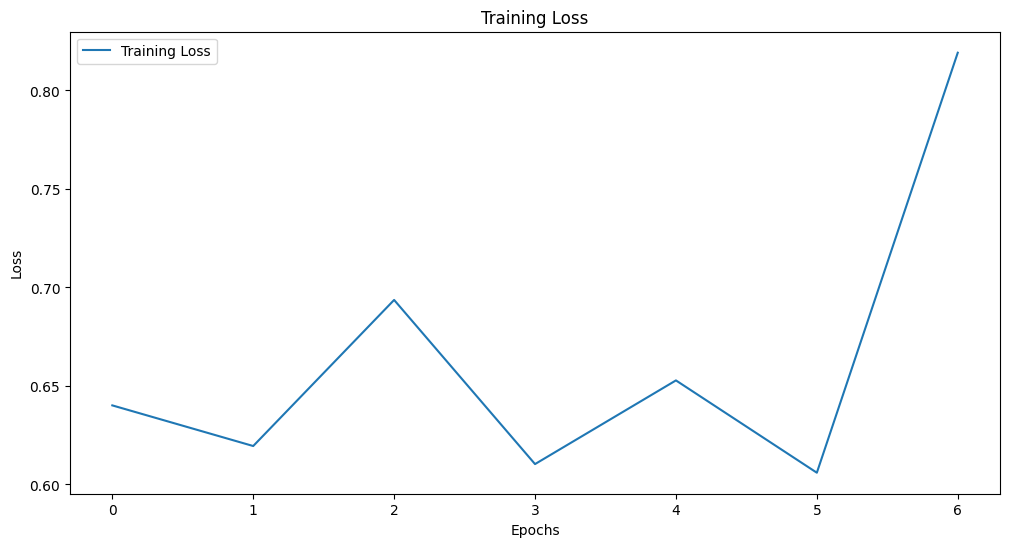

Loss Graph:


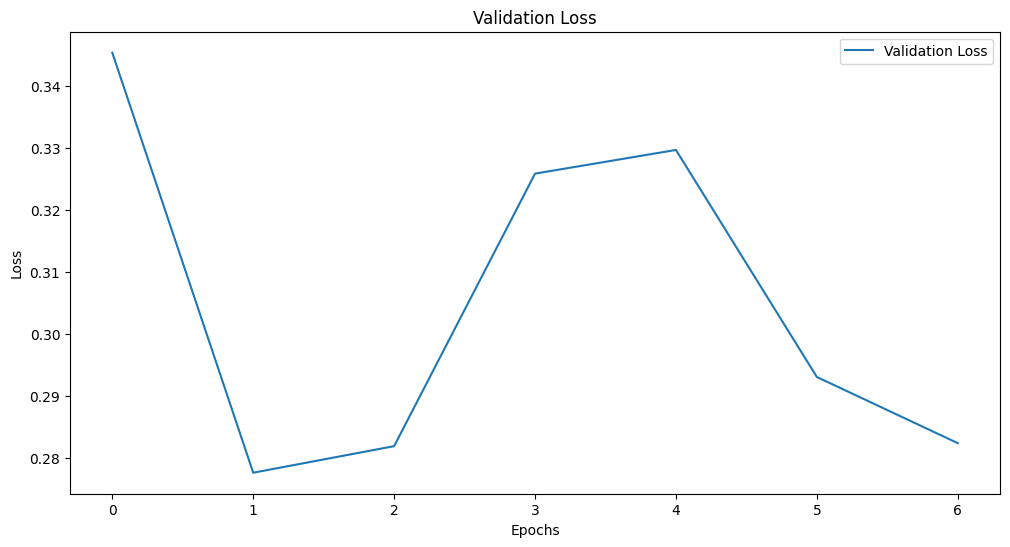

In [59]:
# Display loss graphs
visualize_lstm(history_45)

In [60]:
# Compute predicted spike probabilities
y_pred_45 = model_45.predict(X_test_45).ravel()
y_pred_45

267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


array([0.13946638, 0.10731847, 0.09073482, ..., 0.28396928, 0.25321034,
       0.21843494], dtype=float32)

In [61]:
f1_scores_45 = []

for t in thresholds:
    y_pred = (y_pred_30 >= t).astype(int)
    f1 = f1_score(y_test_30, y_pred)
    f1_scores_45.append(f1)

best_threshold_45 = thresholds[np.argmax(f1_scores_45)]
print("Best threshold (by F1):", best_threshold_45)

Best threshold (by F1): 0.28


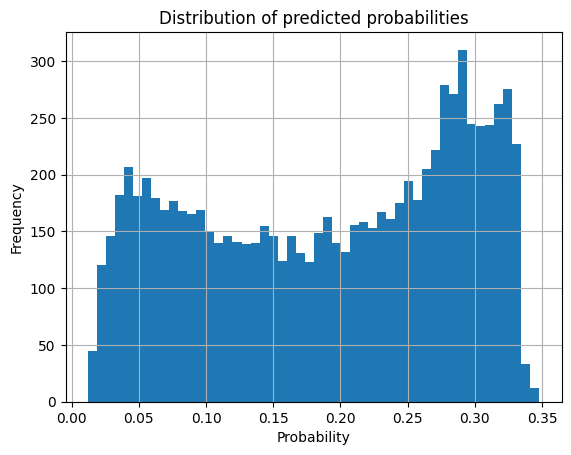

In [62]:
plt.hist(y_pred_45, bins=50)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [63]:
y_pred_45_binary = (y_pred_45 >= 0.28).astype(int)
y_pred_45_binary

array([0, 0, 0, ..., 1, 0, 0])

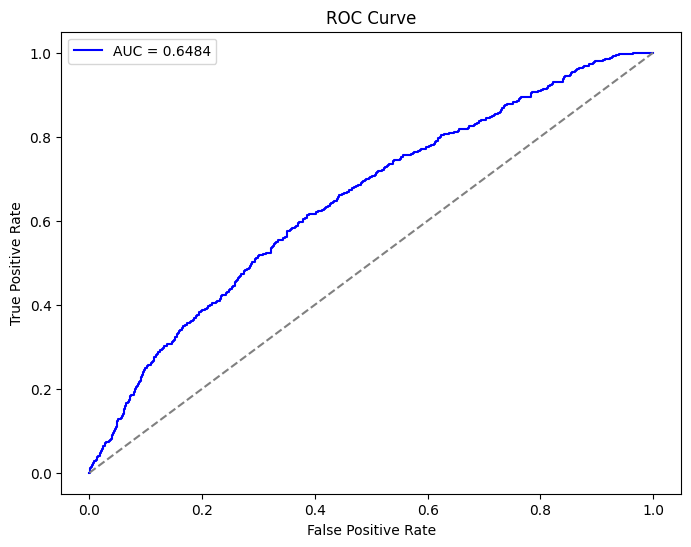

In [64]:
# Display AUC plot
auc_plot(y_test_45, y_pred_45)

1356/1356 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step


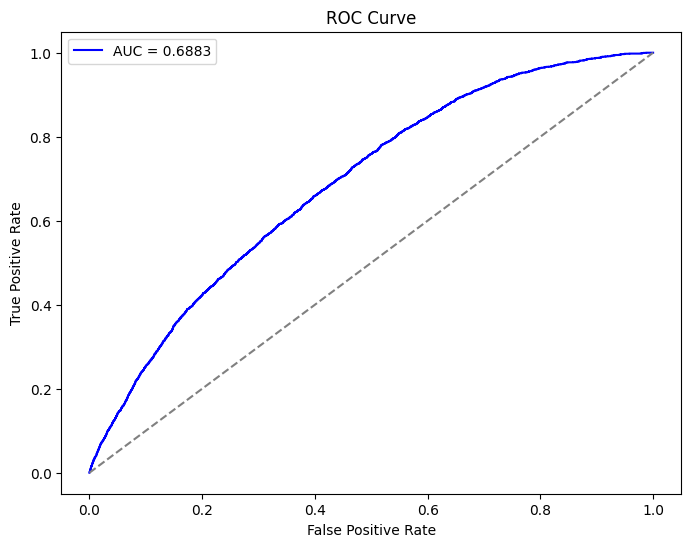

In [65]:
y_pred_train_45 = model_45.predict(X_train_45)
auc_plot(y_train_45, y_pred_train_45)

In [66]:
# Compute average log-likelihood
p_45 = np.clip(y_pred_45, 1e-9, 1 - 1e-9)

log_lik_45 = y_test_45 * np.log(p_45) + (1 - y_test_45) * np.log(1 - p_45)
avg_log_likelihood_45 = np.mean(log_lik_45)

print("Average Log-Likelihood:", avg_log_likelihood_45)

Average Log-Likelihood: -0.27760851991916863


### Threshold: 60

In [67]:
# Build dataset for threshold 30
target_col_60 = 'spike_60'
feature_cols_60 = ['past_spikes_60', 'hdd', 
                   'cdd', 'past_da_load_error', 'past_da_price_error', 'month', 
                   'hour', 'is_weekend', 'is_holiday', 'load_capacity_ratio']

df_60 = df.copy()
df_60 = df_60[[target_col_60] + feature_cols_60]
df_60

,spike_60,past_spikes_60,hdd,cdd,past_da_load_error,past_da_price_error,month,hour,is_weekend,is_holiday,load_capacity_ratio
date,,,,,,,,,,,
2018-01-01 01:00:00,0,0.0,31.252500,0.0,8.657710e+05,18265.332557,1,1,0,0,0.857406
2018-01-01 02:00:00,0,0.0,31.052501,0.0,9.323887e+05,18909.514557,1,2,0,0,0.824816
2018-01-01 03:00:00,0,0.0,30.902500,0.0,9.865578e+05,19498.749824,1,3,0,0,0.825660
2018-01-01 04:00:00,0,0.0,31.252500,0.0,1.030178e+06,20912.901655,1,4,0,0,0.814085
2018-01-01 05:00:00,0,0.0,31.002500,0.0,1.063819e+06,21640.850085,1,5,0,0,0.815584
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0,1.0,12.952500,0.0,2.378046e+05,4643.051269,12,19,1,0,0.845333
2023-12-31 20:00:00,0,0.0,12.902500,0.0,2.293922e+05,955.965258,12,20,1,0,0.816000
2023-12-31 21:00:00,0,0.0,13.252500,0.0,2.295808e+05,916.772151,12,21,1,0,0.786000


In [68]:
# Create a shifted dataset so that we forecast 48h-ahead
# This is needed for the gridsearch
X_60, y_60 = create_seq(df_60, target_col_60, feature_cols_60)

In [128]:
# Perform gridsearch to optimize parameters
shutil.rmtree("untitled_project", ignore_errors=True)
opt_param_60 = gridsearch(X=X_60,
                          y=y_60, 
                          sequence_length=48, 
                          feature_count=len(feature_cols_60))

Trial 10 Complete [00h 06m 21s]
val_loss: 2.548788547515869

Best val_loss So Far: 0.18055811524391174
Total elapsed time: 00h 53m 13s
Optimal units in LSTM_1 layers:  128
Optimal units in LSTM_2 layers:  48
Optimal dropout_1 rate:  0.1
Optimal dropout_2 rate:  0.30000000000000004
Optimal dense layer units:  50


In [69]:
# Build LSTM model (train 2018-2022, test 2023)
train_size = 0.8
model_60, history_60, X_train_60, X_test_60, y_train_60, y_test_60 = lstm_model(dataset=df_60,
                                                                                feature_cols=feature_cols_60,
                                                                                target_col=target_col_60,
                                                                                train_size=train_size, 
                                                                                sequence_len=48,
                                                                                lstm_units1=128,
                                                                                lstm_units2=48,
                                                                                dropout1=0.1,
                                                                                dropout2=0.3,
                                                                                dense_units=50,
                                                                                epochs=30, 
                                                                                batch_size=32)

Fitting the model:
Epoch 1/30


C:\Users\vlari\PycharmProjects\electricty_trading\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1356/1356 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.9600 - loss: 0.5298 - val_accuracy: 0.9651 - val_loss: 0.3141
Epoch 2/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.9608 - loss: 0.5103 - val_accuracy: 0.9651 - val_loss: 0.2166
Epoch 3/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.9615 - loss: 0.4856 - val_accuracy: 0.9651 - val_loss: 0.2177
Epoch 4/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.9624 - loss: 5778.0107 - val_accuracy: 0.9651 - val_loss: 0.2442
Epoch 5/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.9615 - loss: 0.5421 - val_accuracy: 0.9651 - val_loss: 0.2162
Epoch 6/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.9619 - loss: 0.4872 - val_accuracy: 0.9651 - val_loss: 0.2330
Epoch 7/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.9605 - loss: 31.1104 - val_accuracy: 0.9651 - val_loss: 0.2287
Epoch 8/30
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.9595 - loss: 

Loss Graph:


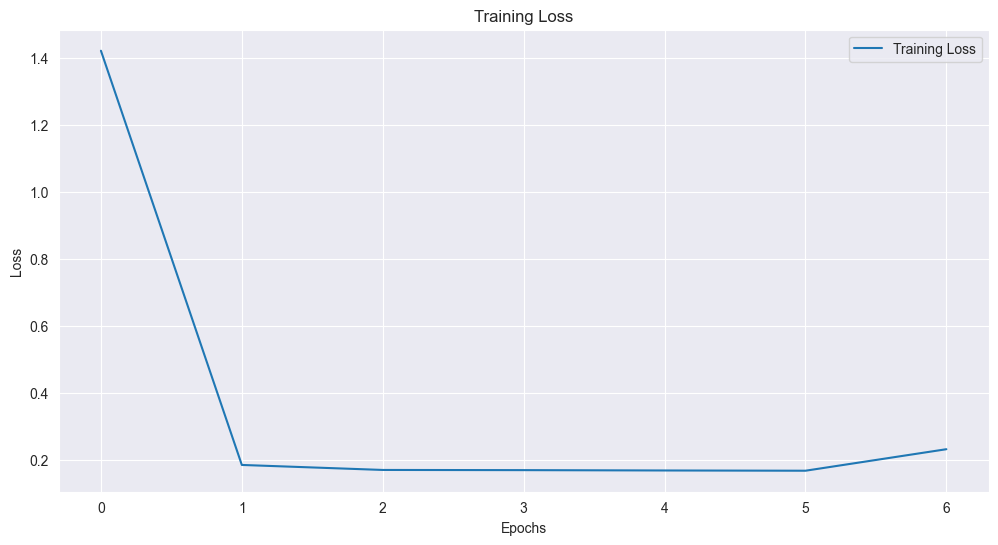

Loss Graph:


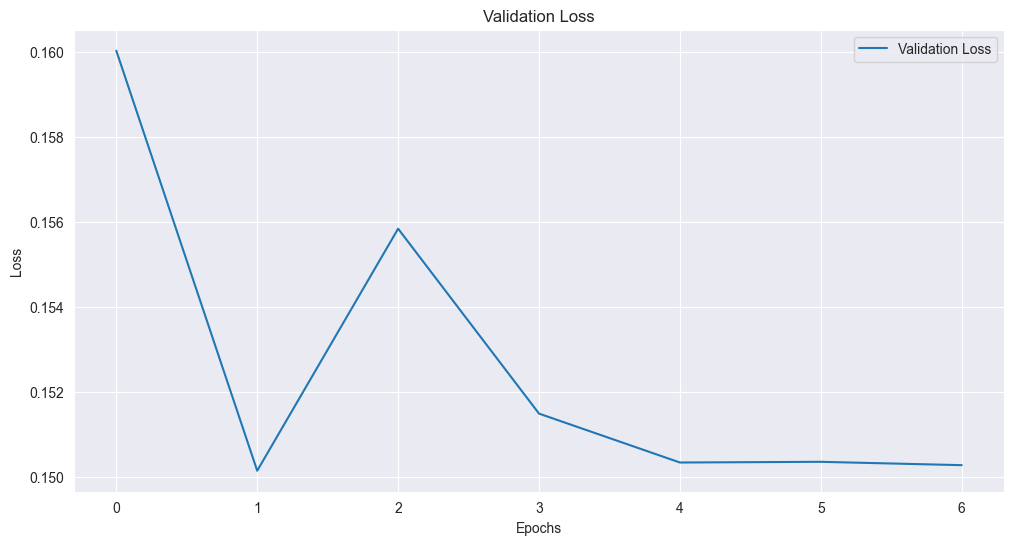

In [207]:
# Display loss graphs
visualize_lstm(history_60)

In [208]:
# Compute predicted spike probabilities
y_pred_60 = model_60.predict(X_test_60).ravel()
y_pred_60

270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


array([0.0333347 , 0.03347008, 0.0335962 , ..., 0.03234419, 0.03237687,
       0.0323675 ], dtype=float32)

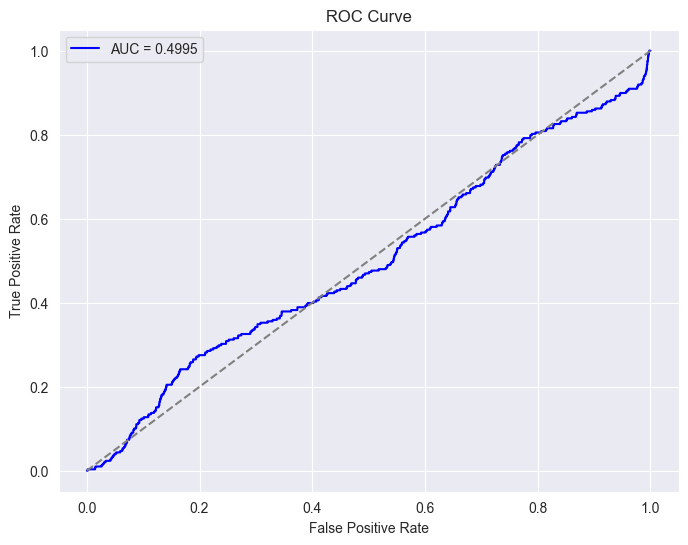

In [209]:
# Display AUC plot
auc_plot(y_test_60, y_pred_60)

In [210]:
# Compute average log-likelihood
p_60 = np.clip(y_pred_60, 1e-9, 1 - 1e-9)

log_lik_60 = y_test_60 * np.log(p_60) + (1 - y_test_60) * np.log(1 - p_60)
avg_log_likelihood_60 = np.mean(log_lik_60)

print("Average Log-Likelihood:", avg_log_likelihood_60)

Average Log-Likelihood: -0.15015071025075094
